In [1]:
import os
import tensorflow as tf
import keras
import pandas as pd
from keras.applications.vgg19 import VGG19
import keras.layers as L
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
print("Training: nb malignant images:", len(os.listdir('../input/skin-cancer-malignant-vs-benign/train/malignant')))
print("Training: nb benign images:", len(os.listdir('../input/skin-cancer-malignant-vs-benign/train/benign')))
print("Test: nb malignant images:", len(os.listdir('../input/skin-cancer-malignant-vs-benign/test/malignant')))
print("Test: nb benign images:", len(os.listdir('../input/skin-cancer-malignant-vs-benign/test/benign')))

Training: nb malignant images: 1197
Training: nb benign images: 1440
Test: nb malignant images: 300
Test: nb benign images: 360


In [3]:
path = '../input/skin-cancer-malignant-vs-benign/data/'
bs = 64
classes = ('Malignant','Benign')[::-1]

In [4]:
gen = ImageDataGenerator(rescale=1/255.)

In [5]:
train_gen = gen.flow_from_directory("../input/skin-cancer-malignant-vs-benign/train/",
                                   target_size=(224, 244),
                                   batch_size=bs,
                                   class_mode='binary')

Found 2637 images belonging to 2 classes.


In [6]:
val_gen = gen.flow_from_directory("../input/skin-cancer-malignant-vs-benign/test/",
                                   target_size=(224, 244),
                                   batch_size=bs,
                                   class_mode='binary')

Found 660 images belonging to 2 classes.


In [7]:
base_model = VGG19(weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [8]:
for layer in base_model.layers[:-15]: layer.trainable = False

In [9]:
X = L.MaxPool2D()(base_model.output)
X = L.GlobalMaxPool2D()(X)
# X = L.Dense(1024, activation='relu')(X)
X = L.Dense(1024, activation='relu')(X)
X = L.Dropout(0.5)(X)
X = L.BatchNormalization()(X)
X = L.Dense(512,activation = 'softmax')(X)
X = L.Dropout(0.3)(X)
X = L.BatchNormalization()(X)
X = L.Dense(256,activation = 'relu')(X)
X = L.BatchNormalization()(X)
X = L.Dense(1, activation='sigmoid')(X)
model = Model(inputs=base_model.input, outputs=X)

In [10]:
len(base_model.layers)

22

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [13]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [14]:
# earlyStopping = EarlyStopping(monitor='val_acc', patience=200, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max')


In [15]:
history = model.fit_generator(train_gen, steps_per_epoch=train_gen.n//bs, epochs=128,
                   validation_data=val_gen, validation_steps=val_gen.n//bs, workers=2,
                   callbacks=[mcp_save])

Epoch 1/128
41/41 [==============================] - 31s 745ms/step - loss: 0.6768 - acc: 0.6611 - val_loss: 0.7061 - val_acc: 0.5422
Epoch 2/128
41/41 [==============================] - 19s 458ms/step - loss: 0.4670 - acc: 0.7866 - val_loss: 0.7326 - val_acc: 0.5570
Epoch 3/128
41/41 [==============================] - 18s 449ms/step - loss: 0.4418 - acc: 0.8061 - val_loss: 0.6720 - val_acc: 0.5386
Epoch 4/128
41/41 [==============================] - 19s 453ms/step - loss: 0.4083 - acc: 0.8076 - val_loss: 0.6679 - val_acc: 0.5604
Epoch 5/128
41/41 [==============================] - 18s 449ms/step - loss: 0.4012 - acc: 0.8185 - val_loss: 0.6488 - val_acc: 0.5185
Epoch 6/128
41/41 [==============================] - 19s 456ms/step - loss: 0.3896 - acc: 0.8243 - val_loss: 0.6588 - val_acc: 0.5889
Epoch 7/128
41/41 [==============================] - 19s 474ms/step - loss: 0.3813 - acc: 0.8290 - val_loss: 0.6784 - val_acc: 0.5621
Epoch 8/128
41/41 [==============================] - 19s 458ms

In [16]:
model.save('model.h5')

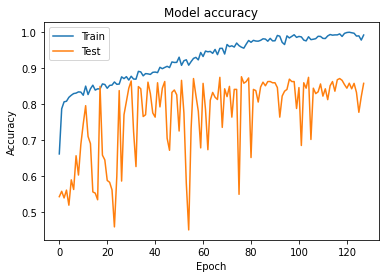

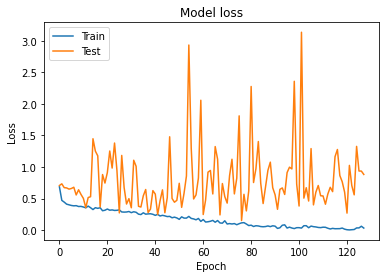

In [17]:

from keras.utils import plot_model
plot_model(model, to_file='model.png')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
model.evaluate_generator(train_gen)

[0.008708843030035496, 0.9715585708618164]

In [19]:
model.evaluate_generator(val_gen)

[1.4564120769500732, 0.842424213886261]

In [20]:
import keras
keras.callbacks.callbacks.History()
keras.callbacks.callbacks.ModelCheckpoint(filepath='/kaggle/working/.ipynb_checkpoints')

In [21]:
#Single Benign Image Testing
import cv2
img = cv2.imread('../input/singleimages/testbenign.jpg')
img = img.reshape((1,*img.shape))
print('Malign' if model.predict(img) > 0.5 else 'Benign')

Malign


In [22]:
#Single Malign Image Testing
img = cv2.imread('../input/singleimages/testsample malign.png')
img = img.reshape((1,*img.shape))
print('Malign' if model.predict(img) > 0.5 else 'Benign')

Malign
